# 1. import liberies

In [1]:
# Essential liberies
import pandas as pd 
import numpy as np
import os
import datetime

# visulialzation liberies
import seaborn as sns
import matplotlib.pyplot as plt 

# classification modules
from sklearn.linear_model import LogisticRegression
from statsmodels.discrete.discrete_model import Logit
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
import statsmodels.api as sm
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier

# evaluation metrics
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_curve, roc_auc_score, f1_score,recall_score, precision_score
from scikitplot.metrics import plot_lift_curve
from sklearn.tree import plot_tree
from scipy.stats import ks_2samp

# preprocessing and data resampling
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import  GridSearchCV, train_test_split,
import category_encoders as ce

# Display options
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

# 2. Import Data

In [2]:
#Campaign Details
cd_df = pd.read_csv('D:/Data Science/Digita schools/Project/Project Marketing Analytics/Datasets/Campaign Details.csv')
 #Campaign Response
cr_df = pd.read_csv('D:/Data Science/Digita schools/Project/Project Marketing Analytics/Datasets/Campaign Response  Data.csv')
 #MasterLookUp
mlu_df = pd.read_csv('D:/Data Science/Digita schools/Project/Project Marketing Analytics/Datasets/MasterLookUp.csv')
 #Transaction
t_df = pd.read_csv('D:/Data Science/Digita schools/Project/Project Marketing Analytics/Datasets/Transaction data.csv')

# 3. EDA and Feature Engineering

In [3]:
#Show samples from each csv file
print('\n Campaign Details \n',cd_df.sample(5))
print('\n Campaign Response\n',cr_df.sample(5))
print('\n MasterLookUp \n',mlu_df.sample(5))
print('\n Transaction \n',t_df.sample(5))


 Campaign Details 
      ChannelPartnerID  email  sms  call
762             61459      1    0     0
407             34680      1    0     1
448             37373      1    1     1
333             30436      1    1     1
870             71313      2    0     1

 Campaign Response
      ChannelPartnerID  response  n_comp  loyalty  portal  rewards  nps  n_yrs
134             37928         0       1        0       0        0    8      5
206             63758         0       4        1       0        1    2      7
488             77780         0       2        0       0        0    8      4
453             52824         0       5        1       0        1    5      5
68              56043         1       2        1       1        1    8      3

 MasterLookUp 
        ChannelPartnerID Region
24682             34682  North
7733              17733   West
21155             31155   West
3238              13238   West
46063             56063  North

 Transaction 
         ChannelPartnerID  Month

In [4]:
# Create master Data frame for EDA
 # group transaction data by unique ChannelPartnerID
t1 = t_df.groupby(['ChannelPartnerID','Brand',])['Sales'].sum()
t1 = t1.reset_index()
t1 = t1.pivot(*t1).fillna(0).add_suffix('_Sales')
t1 = t1.reset_index()

 #Merge Data frame
df_merg1 = pd.merge(t1,cr_df, on='ChannelPartnerID', how='right')
df_merge2 =pd.merge(df_merg1,cd_df, on='ChannelPartnerID', how='left')
df =pd.merge(df_merge2,mlu_df, on='ChannelPartnerID', how='left')
df

,ChannelPartnerID,B1_Sales,B2_Sales,B3_Sales,B4_Sales,B5_Sales,B6_Sales,B7_Sales,response,n_comp,loyalty,portal,rewards,nps,n_yrs,email,sms,call,Region
0,18263,77754.0,0.0,31810.0,48367.0,0.0,0.0,0.0,1,2,1,1,0,7,8,1,1,1,South
1,50429,25750.0,30282.0,57921.0,9085.0,19890.0,0.0,0.0,0,1,1,1,1,3,3,1,1,1,South
2,98593,41355.0,22280.0,164.0,0.0,0.0,0.0,0.0,1,0,1,0,0,9,6,1,2,1,East
3,44804,8366.0,24605.0,0.0,0.0,14131.0,0.0,0.0,0,4,1,1,1,2,5,1,1,1,West
4,81015,38682.0,0.0,29613.0,26425.0,33429.0,0.0,0.0,0,4,1,1,1,2,2,1,1,1,South
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1223,77189,0.0,56667.0,23090.0,2220.0,1476.0,0.0,0.0,0,2,0,0,0,6,4,0,1,0,West
1224,87384,38964.0,27893.0,37578.0,16723.0,71733.0,0.0,0.0,0,3,1,1,1,1,3,1,1,1,East
1225,23574,0.0,0.0,0.0,0.0,13155.0,0.0,0.0,0,2,1,0,1,0,4,1,0,1,West
1226,15136,0.0,55113.0,0.0,20185.0,0.0,0.0,0.0,0,5,1,0,0,6,8,0,1,0,West


In [5]:
 # Create total sales columns and B1 contrubtion to overall sales
df['Total_sales'] = df['B1_Sales'] + df['B2_Sales'] + df['B3_Sales'] + df['B4_Sales'] +df['B5_Sales'] +df['B6_Sales'] +df['B7_Sales']
df['B1_contrubtion'] = df['B1_Sales'] / df['Total_sales']
df

,ChannelPartnerID,B1_Sales,B2_Sales,B3_Sales,B4_Sales,B5_Sales,B6_Sales,B7_Sales,response,n_comp,loyalty,portal,rewards,nps,n_yrs,email,sms,call,Region,Total_sales,B1_contrubtion
0,18263,77754.0,0.0,31810.0,48367.0,0.0,0.0,0.0,1,2,1,1,0,7,8,1,1,1,South,157931.0,0.492329
1,50429,25750.0,30282.0,57921.0,9085.0,19890.0,0.0,0.0,0,1,1,1,1,3,3,1,1,1,South,142928.0,0.180161
2,98593,41355.0,22280.0,164.0,0.0,0.0,0.0,0.0,1,0,1,0,0,9,6,1,2,1,East,63799.0,0.648208
3,44804,8366.0,24605.0,0.0,0.0,14131.0,0.0,0.0,0,4,1,1,1,2,5,1,1,1,West,47102.0,0.177615
4,81015,38682.0,0.0,29613.0,26425.0,33429.0,0.0,0.0,0,4,1,1,1,2,2,1,1,1,South,128149.0,0.301852
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1223,77189,0.0,56667.0,23090.0,2220.0,1476.0,0.0,0.0,0,2,0,0,0,6,4,0,1,0,West,83453.0,0.000000
1224,87384,38964.0,27893.0,37578.0,16723.0,71733.0,0.0,0.0,0,3,1,1,1,1,3,1,1,1,East,192891.0,0.202000
1225,23574,0.0,0.0,0.0,0.0,13155.0,0.0,0.0,0,2,1,0,1,0,4,1,0,1,West,13155.0,0.000000
1226,15136,0.0,55113.0,0.0,20185.0,0.0,0.0,0.0,0,5,1,0,0,6,8,0,1,0,West,75298.0,0.000000


In [6]:
# data visualization 
df_vis = df
df_vis['responsed'] = df_vis['response'].replace({1:'True',0:'False'})

In [7]:
#Chart1 data frame prepreation
df_vis1 = df_vis
df_vis1 = df_vis1.groupby(['Region','responsed'],as_index=False)['response'].count()

Total =[]
for i in df_vis1.Region.unique():  
    m = df_vis1[(df_vis1.Region==i)]['response'].sum()
    Total.append(m)
    Total.append(m)
Total =pd.DataFrame(Total,columns=['Total'])

df_vis1 = pd.concat([df_vis1,Total],axis=1)
df_vis1.dropna(axis=0,inplace=True)
df_vis1['percent'] = 100* df_vis1['response'] / df_vis1['Total']
df_vis1

,Region,responsed,response,Total,percent
0,East,False,208,340,61.176471
1,East,True,132,340,38.823529
2,North,False,186,316,58.860759
3,North,True,130,316,41.139241
4,South,False,175,274,63.868613
5,South,True,99,274,36.131387
6,West,False,167,298,56.040268
7,West,True,131,298,43.959732


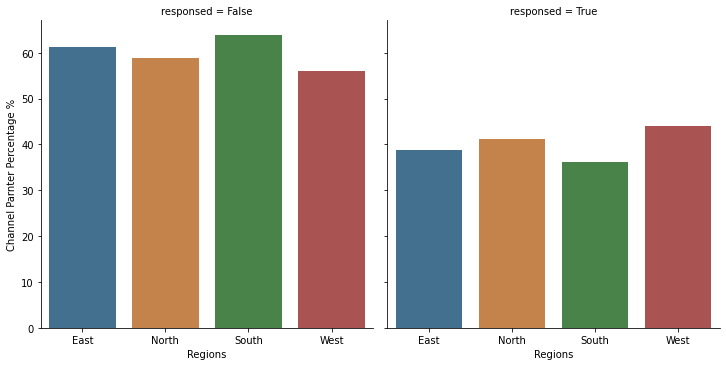

In [8]:
#Chart1 : Channel partner percentage in Regions freqeuncy each  responses value
g = sns.catplot(x="Region", y="percent", col="responsed",
                data=df_vis1, saturation=.5,
                kind="bar", ci=None,)
g.set_xlabels('Regions')
g.set_ylabels('Channel Parnter Percentage %')
plt.savefig('c1.png')                 
plt.show()

In [9]:
#Chart2 data frame prepreation
df_vis2 = df_vis
df_vis2 = df_vis2.groupby(['n_yrs','responsed'],as_index=False)['response'].count()

Total =[]
for i in df_vis2.n_yrs.unique():  
    m = df_vis2[(df_vis2.n_yrs==i)]['response'].sum()
    Total.append(m)
    Total.append(m)
Total =pd.DataFrame(Total,columns=['Total'])
df_vis2 = pd.concat([df_vis2,Total],axis=1)
df_vis2.dropna(axis=0,inplace=True)
df_vis2.Total[(df_vis2.response==27.0)]= 27
df_vis2['percent'] = 100* df_vis2['response'] / df_vis2['Total']
df_vis2

,n_yrs,responsed,response,Total,percent
0,2,False,76,108,70.370370
1,2,True,32,108,29.629630
2,3,False,131,181,72.375691
3,3,True,50,181,27.624309
4,4,False,110,182,60.439560
5,4,True,72,182,39.560440
6,5,False,108,187,57.754011
7,5,True,79,187,42.245989
8,6,False,94,175,53.714286
9,6,True,81,175,46.285714


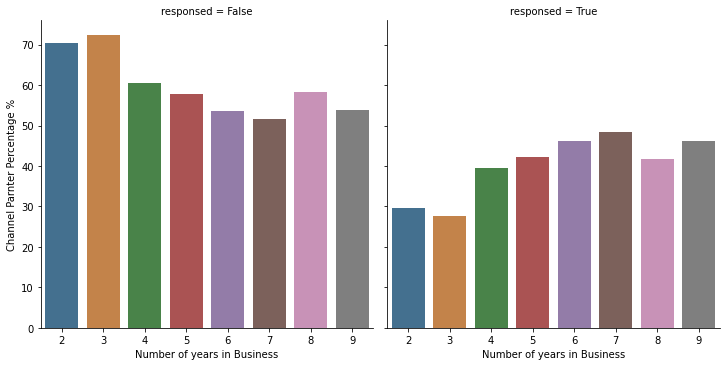

In [10]:
#Chart2 : Channel partner percentage in number of yeaers in business  freqeuncy each  responses value 
g = sns.catplot(x="n_yrs", y="percent", col="responsed",
                data=df_vis2, saturation=.5,
                kind="bar", ci=None,)
g.set_xlabels('Number of years in Business')
g.set_ylabels('Channel Parnter Percentage %')                 
plt.savefig('c2.png')   
plt.show()

<Figure size 720x720 with 0 Axes>

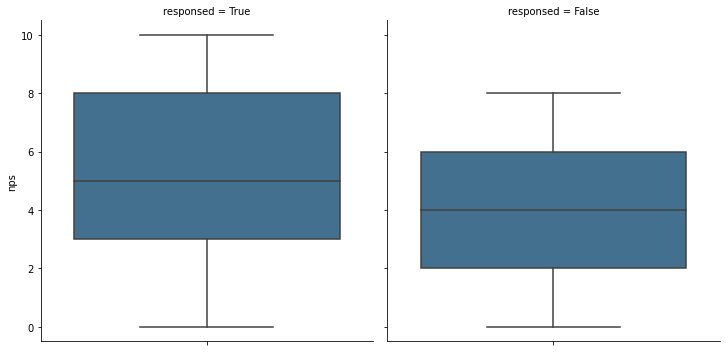

In [11]:
#Chart3 : Net promot scorer freqeuncy for  each responses value
fig = plt.gcf()
fig.set_size_inches(10,10,forward=True)
sns.factorplot(y="nps", col="responsed",
                data=df_vis, saturation=.5,
                kind="box", aspect=1)             
plt.savefig('c3.png')
plt.show()

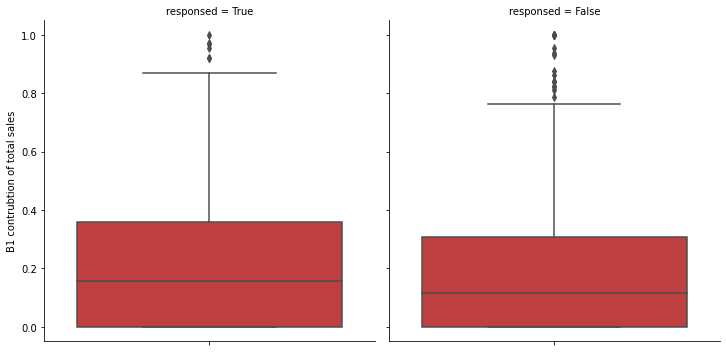

In [12]:
#Chart4 : Net promot scorer freqeuncy for  each responses value
g = sns.factorplot(y="B1_contrubtion", col="responsed",
                data=df_vis, saturation=.5,
                kind="box", aspect=1,color='red')
g.set_ylabels('B1 contrubtion of total sales')              
plt.savefig('c4.png')   
plt.show()

In [13]:
#Chart5 data frame prepreation
t1 = t_df.groupby(['ChannelPartnerID','Brand','Year'],as_index=False)['Sales'].sum()
t1 = t1[(t1.Year==2019)].groupby(['ChannelPartnerID','Year'],as_index=False)['Sales'].sum()
df_merg1 = pd.merge(t1,cr_df, on='ChannelPartnerID', how='right')
df_merge2 =pd.merge(df_merg1,cd_df, on='ChannelPartnerID', how='left')
df1 =pd.merge(df_merge2,mlu_df, on='ChannelPartnerID', how='left')
df1.Year.fillna(2019,inplace=True)
df1.Sales.fillna(0,inplace=True)
df1.rename(columns={'Sales': '2019_Sales'})
df1['responsed'] = df1['response'].replace({1:'True',0:'False'})

,ChannelPartnerID,Year,2019_Sales,response,n_comp,loyalty,portal,rewards,nps,n_yrs,email,sms,call,Region
0,18263,2019.0,112977.0,1,2,1,1,0,7,8,1,1,1,South
1,50429,2019.0,89591.0,0,1,1,1,1,3,3,1,1,1,South
2,98593,2019.0,22280.0,1,0,1,0,0,9,6,1,2,1,East
3,44804,2019.0,22497.0,0,4,1,1,1,2,5,1,1,1,West
4,81015,2019.0,52551.0,0,4,1,1,1,2,2,1,1,1,South
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1223,77189,2019.0,25831.0,0,2,0,0,0,6,4,0,1,0,West
1224,87384,2019.0,173378.0,0,3,1,1,1,1,3,1,1,1,East
1225,23574,2019.0,0.0,0,2,1,0,1,0,4,1,0,1,West
1226,15136,2019.0,55113.0,0,5,1,0,0,6,8,0,1,0,West


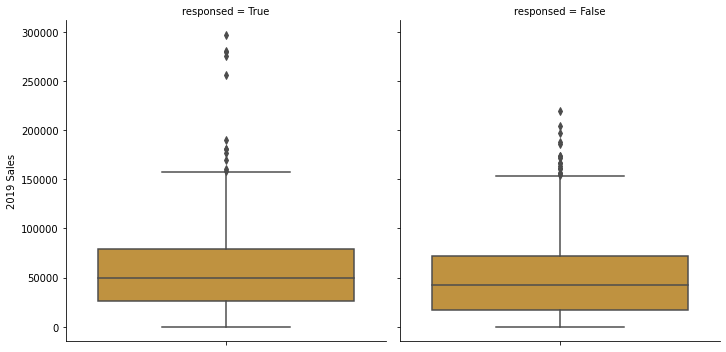

In [15]:
#Chart5 : 2019 Sales freqeuncy for  each responses value
g = sns.factorplot(y="Sales", col="responsed",
                data=df1, saturation=.5,
                kind="box", aspect=1,color='orange')
g.set_ylabels('2019 Sales')
plt.savefig('c5.png')                
plt.show()

In [16]:
#Chart6 data frame prepreation
t1 = t_df.groupby(['ChannelPartnerID','Brand','Year'],as_index=False)['Sales'].sum()
t1 = t1[(t1.Year==2018)].groupby(['ChannelPartnerID','Year'],as_index=False)['Sales'].sum()
df_merg1 = pd.merge(t1,cr_df, on='ChannelPartnerID', how='right')
df_merge2 =pd.merge(df_merg1,cd_df, on='ChannelPartnerID', how='left')
df2 =pd.merge(df_merge2,mlu_df, on='ChannelPartnerID', how='left')
df2.Year.fillna(2018,inplace=True)
df2.Sales.fillna(0,inplace=True)
df2.rename(columns={'Sales': '2018_Sales'})

,ChannelPartnerID,Year,2018_Sales,response,n_comp,loyalty,portal,rewards,nps,n_yrs,email,sms,call,Region
0,18263,2018.0,44954.0,1,2,1,1,0,7,8,1,1,1,South
1,50429,2018.0,53337.0,0,1,1,1,1,3,3,1,1,1,South
2,98593,2018.0,41519.0,1,0,1,0,0,9,6,1,2,1,East
3,44804,2018.0,24605.0,0,4,1,1,1,2,5,1,1,1,West
4,81015,2018.0,75598.0,0,4,1,1,1,2,2,1,1,1,South
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1223,77189,2018.0,57622.0,0,2,0,0,0,6,4,0,1,0,West
1224,87384,2018.0,19513.0,0,3,1,1,1,1,3,1,1,1,East
1225,23574,2018.0,13155.0,0,2,1,0,1,0,4,1,0,1,West
1226,15136,2018.0,20185.0,0,5,1,0,0,6,8,0,1,0,West


In [17]:
#Chart6: Respones vs Loyalty crosstable
c6 = pd.crosstab(df1.response,df1.loyalty,)
c6

loyalty,0,1
response,,
0,366,370
1,156,336


In [18]:
#Chart7: Respones vs Calls crosstable
c7 = pd.crosstab(df1.response ,df1.call)
c7

call,0,1,2,3,4,5
response,,,,,,
0,368,366,2,0,0,0
1,159,274,45,12,1,1


In [19]:
#Chart8: Respones vs SMS crosstable
pd.crosstab(df1.response,df1.sms)


sms,0,1,2,3,4
response,,,,,
0,244,469,22,0,1
1,172,285,29,4,2


In [20]:
# Chart 9 : Responses vs Email crosstable : 
pd.crosstab(df1.response , df1.email)


email,0,1,2,3,4
response,,,,,
0,311,408,17,0,0
1,107,329,49,6,1


# insights from EDA
### 1- for all Regions the percent of the channel partner who didn't response is larger than responded, same thing for number of years in business.
### 2- the west reigon has the highest response rate with 44% and south region has the lowest one with 36%, but in general I could say that all regions had same response rate.
### 3- the response rate increase when the channel partner has longer period in buisness with the company.
### 4- all 2019 sales , Net Promote scorer and Coffee sales contributions to overall sales frequency had simliar  values for both responded and not responded channel partner.
### 5- Customers not in loyalty program tent more to not response to the campain.
### 6- Channel Partner don't response to call after the first one.
### 7- sending more than 2 sms  or emails for each channel partner is not effective as matter of responsiveness.

In [21]:
# Create master Data frame for model building with feature engineering
# master Data frame file
t1=t_df
t1['date']=pd.to_datetime(t1[['Year', 'Month']].assign(DAY=1))
t1=t_df.pivot_table(index=['ChannelPartnerID','Year'],columns=['Brand'],values=['Sales']).reset_index()
t1.fillna(0,inplace=True)
t1.columns=t1.columns.map('_'.join)
t1=t1.pivot_table(index=['ChannelPartnerID_'],columns=['Year_'],values=['Sales_B1','Sales_B2','Sales_B3','Sales_B4','Sales_B5','Sales_B6','Sales_B7']).reset_index(level='ChannelPartnerID_')
t1.fillna(0,inplace=True)
t1.columns=t1.columns.droplevel(1)
t1.columns=['ChannelPartnerID', '2018_Sales_B1', '2019_Sales_B1', '2018_Sales_B2', '2019_Sales_B2',
            '2018_Sales_B3', '2019_Sales_B3', '2018_Sales_B4', '2019_Sales_B4', '2018_Sales_B5',
            '2019_Sales_B5','2018_Sales_B6', '2019_Sales_B6', '2018_Sales_B7', '2019_Sales_B7']
sales_2018=['2018_Sales_B1','2018_Sales_B2','2018_Sales_B3','2018_Sales_B4','2018_Sales_B5','2018_Sales_B6','2018_Sales_B7'] 
sales_2019=['2019_Sales_B1','2019_Sales_B2','2019_Sales_B3','2019_Sales_B4','2019_Sales_B5','2019_Sales_B6','2019_Sales_B7']

# 2018 Total sales
t1['2018_total_sales']=t1[sales_2018].sum(axis=1)

# 2019 Total sales
t1['2019_total_sales']=t1[sales_2019].sum(axis=1)
t1.fillna(0,inplace=True)

# Total sales
t1['total sales']=t1['2018_total_sales']+t1['2018_total_sales']

# brand engagement for coffee
t1['Brand_engaement_2019']=((t1[sales_2019]>0)* 1).sum(axis=1)

# Coffee contribution to total sales
t1['Contribution_B1']=((t1['2018_Sales_B1']+t1['2019_Sales_B1'])/t1['total sales']).fillna(0)
t1['Contribution_B1']=t1['Contribution_B1'].replace(np.Inf,0)

# buying frequency
t2=t_df[['ChannelPartnerID']].value_counts().reset_index()
t2=t2.rename(columns={0: 'buying_Frequency'})

# Coffee buying frequency
t3=t_df[['ChannelPartnerID']][(t_df['Brand']=='B1')].value_counts().reset_index()
t3=t3.rename(columns={0: 'B1_buying_Frequency'})

# Brand activation in last quarter
t4=t_df
t4['date']=pd.to_datetime(t4[['Year', 'Month']].assign(DAY=1))
last_day=datetime.datetime(2019, 12, 31)
t4['last_engament']=last_day - t4['date'] 
t4['active_in_last_quarter']=[0 if i>datetime.timedelta(days=92) else 1 for i in t_df['last_engament']]
t4=t4.sort_values(by='date',ascending=False).drop_duplicates(keep='last',subset=['ChannelPartnerID'])

# Merge features in one Data frame
t=pd.merge(t1,t2, on='ChannelPartnerID')
t=pd.merge(t,t4, on='ChannelPartnerID')
t=pd.merge(t,t3, on='ChannelPartnerID', how='left')

# Subset selected feature for building model
t=t[['ChannelPartnerID','2018_total_sales','2019_total_sales','2019_Sales_B1','Contribution_B1','B1_buying_Frequency','Brand_engaement_2019','active_in_last_quarter','buying_Frequency']]

# fill missing values with 0 
t=t.fillna(0)
t

,ChannelPartnerID,2018_total_sales,2019_total_sales,2019_Sales_B1,Contribution_B1,B1_buying_Frequency,Brand_engaement_2019,active_in_last_quarter,buying_Frequency
0,10000,19286.500000,60108.000000,29630.0,0.768154,1.0,4,0,6
1,10001,14612.000000,34317.500000,13238.5,0.453001,2.0,2,0,5
2,10002,49917.000000,0.000000,0.0,0.066601,1.0,0,0,3
3,10003,27844.000000,0.000000,0.0,0.000000,0.0,0,0,2
4,10004,32573.000000,69882.000000,6783.0,0.104120,1.0,3,0,4
...,...,...,...,...,...,...,...,...,...
89660,99995,8800.000000,75809.500000,21253.0,1.707557,3.0,4,0,9
89661,99996,54273.333333,59291.000000,14228.0,0.131077,2.0,3,0,12
89662,99997,42627.000000,44156.333333,0.0,0.248469,1.0,2,0,10
89663,99998,81317.400000,17878.000000,8942.0,0.459668,2.0,2,0,9


In [22]:
# Create master Data frame for model building with feature engineering
df_merg1 = pd.merge(t,cr_df, on='ChannelPartnerID', how='right')
df_merge2 =pd.merge(df_merg1,cd_df, on='ChannelPartnerID', how='left')
df =pd.merge(df_merge2,mlu_df, on='ChannelPartnerID', how='left')
master=df
master=master.replace(np.Inf,0)
master=master.fillna(0)
master

,ChannelPartnerID,2018_total_sales,2019_total_sales,2019_Sales_B1,Contribution_B1,B1_buying_Frequency,Brand_engaement_2019,active_in_last_quarter,buying_Frequency,response,n_comp,loyalty,portal,rewards,nps,n_yrs,email,sms,call,Region
0,18263,44954.0,88793.5,32800.0,0.864817,2.0,3.0,0.0,5.0,1,2,1,1,0,7,8,1,1,1,South
1,50429,53337.0,50977.0,0.0,0.241390,1.0,3.0,0.0,9.0,0,1,1,1,1,3,3,1,1,1,South
2,98593,41519.0,22280.0,0.0,0.498025,1.0,1.0,0.0,3.0,1,0,1,0,0,9,6,1,2,1,East
3,44804,24605.0,22497.0,8366.0,0.170006,1.0,2.0,0.0,3.0,0,4,1,1,1,2,5,1,1,1,West
4,81015,44077.0,52551.0,27159.0,0.438800,2.0,2.0,0.0,8.0,0,4,1,1,1,2,2,1,1,1,South
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1223,77189,41466.0,25093.0,0.0,0.000000,0.0,2.0,0.0,7.0,0,2,0,0,0,6,4,0,1,0,West
1224,87384,19513.0,143201.0,38964.0,0.998411,1.0,5.0,0.0,8.0,0,3,1,1,1,1,3,1,1,1,East
1225,23574,13155.0,0.0,0.0,0.000000,0.0,0.0,0.0,1.0,0,2,1,0,1,0,4,1,0,1,West
1226,15136,20185.0,18371.0,0.0,0.000000,0.0,1.0,0.0,4.0,0,5,1,0,0,6,8,0,1,0,West


In [23]:
#oneHotEncoding for Regions
encoder=ce.OneHotEncoder(cols='Region',return_df=True,use_cat_names=True)
master= encoder.fit_transform(master)

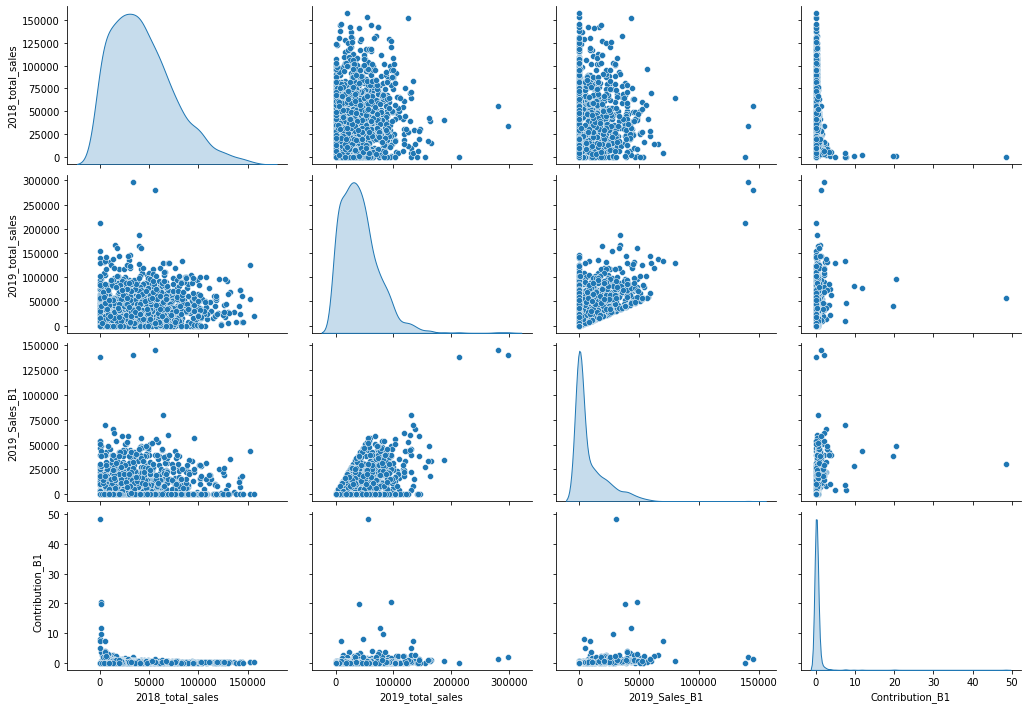

In [24]:
# numerical data distribution 
numeric=['2018_total_sales','2019_total_sales','2019_Sales_B1','Contribution_B1']
sns.pairplot(master[numeric], diag_kind="kde")
plt.gcf().set_size_inches(15, 10)

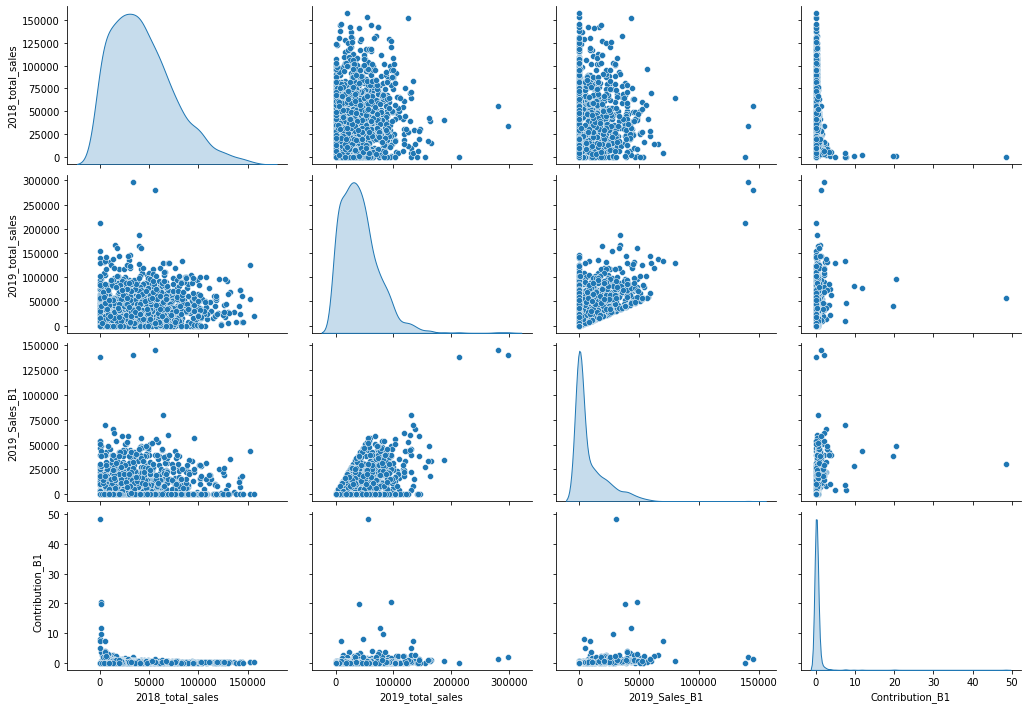

In [25]:
#replace outlayers using Standard Deviations by replacing all data out 3 times standard deviation larger or smaller from the mean with mean
for i in numeric:
  mean, std = master[i].mean(), master[i].std()
  cut_off = std * 2
  lower, upper = mean - cut_off, mean + cut_off
# identify outliers
  master[[i]]=master[[i]].replace(master[i][(master[i] < lower)],mean)
  master[[i]]=master[[i]].replace(master[i][(master[i] > upper)],mean)
sns.pairplot(master[numeric], diag_kind="kde")
plt.gcf().set_size_inches(15, 10)

In [26]:
# Standrize numerical variables
scaler=MinMaxScaler()
master[numeric]=scaler.fit_transform(master[numeric])
master

,ChannelPartnerID,2018_total_sales,2019_total_sales,2019_Sales_B1,Contribution_B1,B1_buying_Frequency,Brand_engaement_2019,active_in_last_quarter,buying_Frequency,response,n_comp,loyalty,portal,rewards,nps,n_yrs,email,sms,call,Region_South,Region_East,Region_West,Region_North
0,18263,0.286495,0.299161,0.226207,0.017849,2.0,3.0,0.0,5.0,1,2,1,1,0,7,8,1,1,1,1,0,0,0
1,50429,0.339921,0.171751,0.000000,0.004982,1.0,3.0,0.0,9.0,0,1,1,1,1,3,3,1,1,1,1,0,0,0
2,98593,0.264604,0.075065,0.000000,0.010279,1.0,1.0,0.0,3.0,1,0,1,0,0,9,6,1,2,1,0,1,0,0
3,44804,0.156810,0.075796,0.057697,0.003509,1.0,2.0,0.0,3.0,0,4,1,1,1,2,5,1,1,1,0,0,1,0
4,81015,0.280906,0.177054,0.187303,0.009056,2.0,2.0,0.0,8.0,0,4,1,1,1,2,2,1,1,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1223,77189,0.264266,0.084543,0.000000,0.000000,0.0,2.0,0.0,7.0,0,2,0,0,0,6,4,0,1,0,0,0,1,0
1224,87384,0.124358,0.482470,0.268717,0.020606,1.0,5.0,0.0,8.0,0,3,1,1,1,1,3,1,1,1,0,1,0,0
1225,23574,0.083838,0.000000,0.000000,0.000000,0.0,0.0,0.0,1.0,0,2,1,0,1,0,4,1,0,1,0,0,1,0
1226,15136,0.128641,0.061895,0.000000,0.000000,0.0,1.0,0.0,4.0,0,5,1,0,0,6,8,0,1,0,0,0,1,0


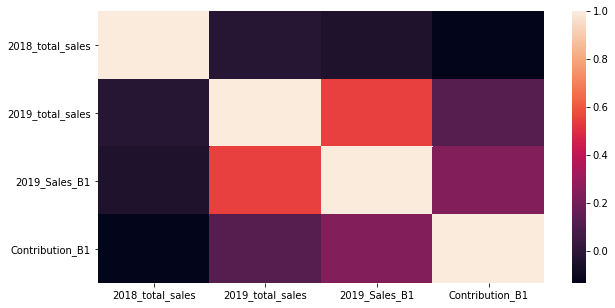

In [27]:
# Pearson Correlation coef between numerical variables
corrlation=master[numeric].corr()
plt.figure(figsize=(10,5))
sns.heatmap(corrlation)
plt.show()

# 4. Model Development

In [28]:
# Seperate dependent variable from the independents
x=master.drop(['response','ChannelPartnerID'],axis=1)
y=master[['response']]

In [29]:
# Check impalance in the data set
y.value_counts()

response
0           736
1           492
dtype: int64

In [30]:
# handling the impalance 
smote= SMOTE(sampling_strategy='minority')
x,y= smote.fit_resample(x,y)
y.value_counts()

response
0           736
1           736
dtype: int64

In [31]:
# check Multicollinearity
VIF={}
VIF['Variables']=x.columns
VIF['VIF'] = [variance_inflation_factor(x.values, i)
                          for i in range(len(x.columns))]
VIF=pd.DataFrame.from_dict(VIF)
VIF.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
Variables,2018_total_sales,2019_total_sales,2019_Sales_B1,Contribution_B1,B1_buying_Frequency,Brand_engaement_2019,active_in_last_quarter,buying_Frequency,n_comp,loyalty,portal,rewards,nps,n_yrs,email,sms,call,Region_South,Region_East,Region_West,Region_North
VIF,4.487151,6.847308,2.65093,1.150607,3.432039,12.932277,1.015602,18.460329,3.641382,5.113925,2.970009,4.619214,3.569378,6.548228,4.350996,3.874851,3.847145,2.487309,2.900472,2.667898,2.887695


In [32]:
# Drop variables with VIF > 5 
x=x.drop(['2019_total_sales','buying_Frequency','n_yrs'],axis=1)

In [33]:
# recalculate 
VIF={}
VIF['Variables']=x.columns
VIF['VIF'] = [variance_inflation_factor(x.values, i)
                          for i in range(len(x.columns))]
VIF=pd.DataFrame.from_dict(VIF)
VIF.T    

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
Variables,2018_total_sales,2019_Sales_B1,Contribution_B1,B1_buying_Frequency,Brand_engaement_2019,active_in_last_quarter,n_comp,loyalty,portal,rewards,nps,email,sms,call,Region_South,Region_East,Region_West,Region_North
VIF,3.016218,1.76906,1.147258,2.810797,4.707412,1.012282,3.577165,4.998707,2.966899,4.578469,3.335806,4.238503,3.789139,3.84621,2.34962,2.705111,2.513667,2.697666


In [34]:
# split data into  80% trainning and 20% testing sets
seed=7
x_train,x_test,y_train,y_test= train_test_split(x,y,test_size=0.2,stratify=y,random_state=seed)
print(len(x_train),len(x_test))

1177 295


###  1. Logistic Regression

In [35]:
# add constant to the variables and fit the logistic model
x_trains = sm.add_constant(x_train)
model=Logit(y_train,x_trains).fit()
print(model.summary())

         Current function value: 0.433088
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:               response   No. Observations:                 1177
Model:                          Logit   Df Residuals:                     1158
Method:                           MLE   Df Model:                           18
Date:                Thu, 24 Mar 2022   Pseudo R-squ.:                  0.3752
Time:                        11:08:16   Log-Likelihood:                -509.74
converged:                      False   LL-Null:                       -815.83
Covariance Type:            nonrobust   LLR p-value:                2.291e-118
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     20.8012   1.19e+04      0.002      0.999   -2.34e+04    2.34e+04
2018_total_sales           0.

C:\Users\KHALID\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [36]:
# drop insiginficant variables
x_trains=x_trains.drop(['2018_total_sales','Region_South','Region_East','Region_West','Region_North'],axis=1)
x_test=x_test.drop(['2018_total_sales','Region_South','Region_East','Region_West','Region_North'],axis=1)

In [37]:
# Refit logstic Model
model=Logit(y_train,x_trains).fit()
print(model.summary())

         Current function value: 0.500145
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:               response   No. Observations:                 1177
Model:                          Logit   Df Residuals:                     1163
Method:                           MLE   Df Model:                           13
Date:                Thu, 24 Mar 2022   Pseudo R-squ.:                  0.2784
Time:                        11:08:16   Log-Likelihood:                -588.67
converged:                      False   LL-Null:                       -815.83
Covariance Type:            nonrobust   LLR p-value:                 7.171e-89
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -2.4955      0.312     -7.989      0.000      -3.108      -1.883
2019_Sales_B1              1.

C:\Users\KHALID\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [38]:
# predict probabilities and create confusion matric  
pred=model.predict()
thres=0.5
pred_class=np.zeros(pred.shape)
pred_class[pred>thres]=1
cm=confusion_matrix(y_train,pred_class)
print(cm)

[[489 100]
 [190 398]]


In [39]:
# classfication report 
classi=classification_report(y_train,pred_class)
print(classi)

              precision    recall  f1-score   support

           0       0.72      0.83      0.77       589
           1       0.80      0.68      0.73       588

    accuracy                           0.75      1177
   macro avg       0.76      0.75      0.75      1177
weighted avg       0.76      0.75      0.75      1177



In [40]:
# train logistic model using sklrean library 
x_train=x_train.drop(['2018_total_sales','Region_South','Region_East','Region_West','Region_North'],axis=1)
model=LogisticRegression(max_iter=10000,random_state=seed)
model.fit(x_train,y_train)

print('acurracy on testing:',model.score(x_test,y_test))
print('accuracy on trainning:',model.score(x_train,y_train))

acurracy on testing: 0.752542372881356
accuracy on trainning: 0.7553101104502974


In [41]:
# confusion matrix and classification report
y_pred=model.predict(x_test)
y_scores = model.predict_proba(x_test)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[121  26]
 [ 47 101]]
              precision    recall  f1-score   support

           0       0.72      0.82      0.77       147
           1       0.80      0.68      0.73       148

    accuracy                           0.75       295
   macro avg       0.76      0.75      0.75       295
weighted avg       0.76      0.75      0.75       295



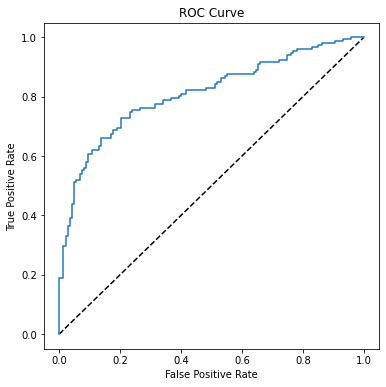

In [42]:
# calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_scores[:,1])

# plot ROC curve
fig = plt.figure(figsize=(6, 6))

# Plot the diagonal 50% line
plt.plot([0, 1], [0, 1], 'k--')

# Plot the FPR and TPR achieved by our model
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [43]:
# calculate AUC
auc = roc_auc_score(y_test,y_scores[:,1])
print('AUC: ' + str(auc))

AUC: 0.811408347122633


### 2. Naive Bayes

In [44]:
# Naive Bayes 
# train a Naive Bayes  model on the training set
nvmodel=GaussianNB()
nvmodel.fit(x_train,y_train)
print('acurracy on testing:',nvmodel.score(x_test,y_test))
print('accuracy on trainning:',nvmodel.score(x_train,y_train))

acurracy on testing: 0.49830508474576274
accuracy on trainning: 0.5038232795242141


In [45]:
#confusion matrix and classification report
y_pred=nvmodel.predict(x_test)
y_scores=nvmodel.predict_proba(x_test)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[  2 145]
 [  3 145]]
              precision    recall  f1-score   support

           0       0.40      0.01      0.03       147
           1       0.50      0.98      0.66       148

    accuracy                           0.50       295
   macro avg       0.45      0.50      0.34       295
weighted avg       0.45      0.50      0.35       295



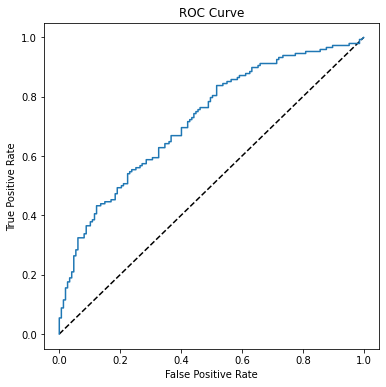

AUC: 0.720881595881596


In [46]:
# calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_scores[:,1])

# plot ROC curve
fig = plt.figure(figsize=(6, 6))

# Plot the diagonal 50% line
plt.plot([0, 1], [0, 1], 'k--')

# Plot the FPR and TPR achieved by our model
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

# calculate AUC
auc = roc_auc_score(y_test,y_scores[:,1])
print('AUC: ' + str(auc))

### 3. Decision tree

decision tree accuracy on trainning: 0.8190314358538657
decision tree acurracy on testing: 0.7694915254237288


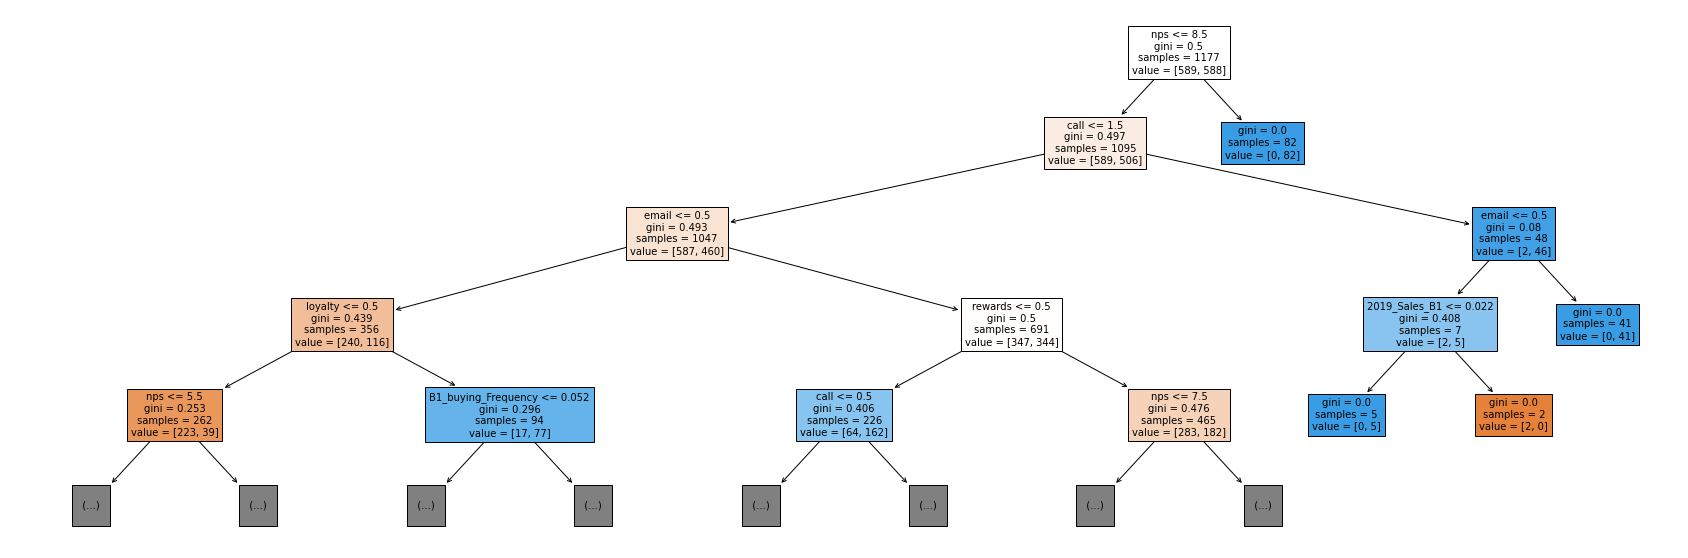

In [47]:
## Decision tree
# train a Decision tree model on the training set
dtmodel= DecisionTreeClassifier(max_depth=8,random_state=seed)
dtmodel.fit(x_train,y_train)
print('decision tree accuracy on trainning:',dtmodel.score(x_train,y_train))
print('decision tree acurracy on testing:',dtmodel.score(x_test,y_test))

# plot the tree
plt.figure(figsize=(30,10))
plot_tree(dtmodel,filled=True,feature_names=list(x_train.columns),max_depth=4,fontsize=10)
plt.show()

In [48]:
#confusion matrix and classification report
y_pred=dtmodel.predict(x_test)
y_scores=dtmodel.predict_proba(x_test)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[132  15]
 [ 53  95]]
              precision    recall  f1-score   support

           0       0.71      0.90      0.80       147
           1       0.86      0.64      0.74       148

    accuracy                           0.77       295
   macro avg       0.79      0.77      0.77       295
weighted avg       0.79      0.77      0.77       295



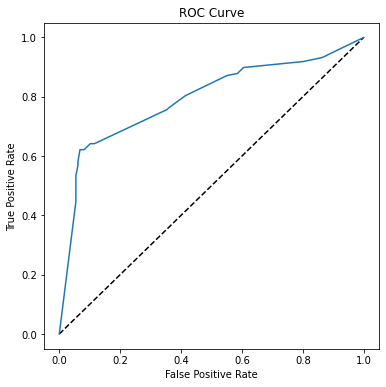

AUC: 0.7936890972605257


In [49]:
# calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_scores[:,1])

# plot ROC curve
fig = plt.figure(figsize=(6, 6))

# Plot the diagonal 50% line
plt.plot([0, 1], [0, 1], 'k--')

# Plot the FPR and TPR achieved by our model
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

# calculate AUC
auc = roc_auc_score(y_test,y_scores[:,1])
print('AUC: ' + str(auc))

### 3. Support Vector machine

In [50]:
# Support Vector machine
svmmodel = SVC(C=0.01,probability=True)
svmmodel.fit(x_train,y_train)
print('Support Vector machine accuracy on trainning:',svmmodel.score(x_train,y_train))
print('Support Vector machine acurracy on testing:',svmmodel.score(x_test,y_test))

Support Vector machine accuracy on trainning: 0.5964316057774002
Support Vector machine acurracy on testing: 0.6067796610169491


In [51]:
#confusion matrix and classification report
y_pred=svmmodel.predict(x_test)
y_scores=svmmodel.predict_proba(x_test)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[136  11]
 [105  43]]
              precision    recall  f1-score   support

           0       0.56      0.93      0.70       147
           1       0.80      0.29      0.43       148

    accuracy                           0.61       295
   macro avg       0.68      0.61      0.56       295
weighted avg       0.68      0.61      0.56       295



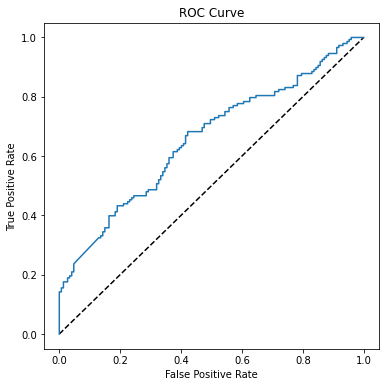

AUC: 0.6552215480786909


In [52]:
# calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_scores[:,1])

# plot ROC curve
fig = plt.figure(figsize=(6, 6))

# Plot the diagonal 50% line
plt.plot([0, 1], [0, 1], 'k--')

# Plot the FPR and TPR achieved by our model
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

# calculate AUC
auc = roc_auc_score(y_test,y_scores[:,1])
print('AUC: ' + str(auc))

### 4. K-Nearest Neighbors

In [53]:
# K-Nearest Neighbors
knnmodel = KNeighborsClassifier(n_neighbors=15)
knnmodel.fit(x_train,y_train)
print('K-Nearest Neighbors accuracy on trainning:',knnmodel.score(x_train,y_train))
print('K-Nearest Neighbors acurracy on testing:',knnmodel.score(x_test,y_test))

K-Nearest Neighbors accuracy on trainning: 0.72982158028887
K-Nearest Neighbors acurracy on testing: 0.6779661016949152


In [54]:
#confusion matrix and classification report
y_pred=knnmodel.predict(x_test)
y_scores=knnmodel.predict_proba(x_test)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[118  29]
 [ 66  82]]
              precision    recall  f1-score   support

           0       0.64      0.80      0.71       147
           1       0.74      0.55      0.63       148

    accuracy                           0.68       295
   macro avg       0.69      0.68      0.67       295
weighted avg       0.69      0.68      0.67       295



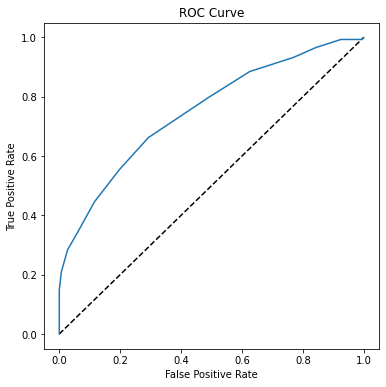

AUC: 0.7507813936385366


In [55]:
# calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_scores[:,1])

# plot ROC curve
fig = plt.figure(figsize=(6, 6))

# Plot the diagonal 50% line
plt.plot([0, 1], [0, 1], 'k--')

# Plot the FPR and TPR achieved by our model
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

# calculate AUC
auc = roc_auc_score(y_test,y_scores[:,1])
print('AUC: ' + str(auc))

### 5. Random Forest

In [56]:
# Random Forest 
rmmodel = RandomForestClassifier(max_depth=7,random_state=seed)
rmmodel.fit(x_train,y_train)
print('Random Forest accuracy on trainning:',rmmodel.score(x_train,y_train))
print('Random Forest acurracy on testing:',rmmodel.score(x_test,y_test))

Random Forest accuracy on trainning: 0.8360237892948174
Random Forest acurracy on testing: 0.7966101694915254


In [57]:
#confusion matrix and classification report
y_pred=rmmodel.predict(x_test)
y_scores=rmmodel.predict_proba(x_test)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[131  16]
 [ 44 104]]
              precision    recall  f1-score   support

           0       0.75      0.89      0.81       147
           1       0.87      0.70      0.78       148

    accuracy                           0.80       295
   macro avg       0.81      0.80      0.79       295
weighted avg       0.81      0.80      0.79       295



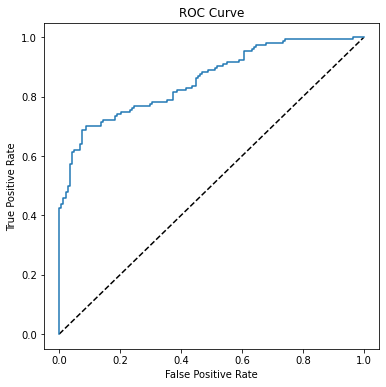

AUC: 0.8567751424894282


In [58]:
# calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_scores[:,1])

# plot ROC curve
fig = plt.figure(figsize=(6, 6))

# Plot the diagonal 50% line
plt.plot([0, 1], [0, 1], 'k--')

# Plot the FPR and TPR achieved by our model
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

# calculate AUC
auc = roc_auc_score(y_test,y_scores[:,1])
print('AUC: ' + str(auc))

### 5. adaptive boosting

In [59]:
# adaptive boosting 
abmodel = AdaBoostClassifier(learning_rate=0.01,n_estimators=100,random_state=seed)
abmodel.fit(x_train,y_train)
print('adaptive boosting acurracy on testing:',abmodel.score(x_test,y_test))
print('adaptive boosting accuracy on trainning:',abmodel.score(x_train,y_train))

adaptive boosting acurracy on testing: 0.6271186440677966
adaptive boosting accuracy on trainning: 0.6074766355140186


In [60]:
#confusion matrix and classification report
y_pred=abmodel.predict(x_test)
y_scores=abmodel.predict_proba(x_test)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[147   0]
 [110  38]]
              precision    recall  f1-score   support

           0       0.57      1.00      0.73       147
           1       1.00      0.26      0.41       148

    accuracy                           0.63       295
   macro avg       0.79      0.63      0.57       295
weighted avg       0.79      0.63      0.57       295



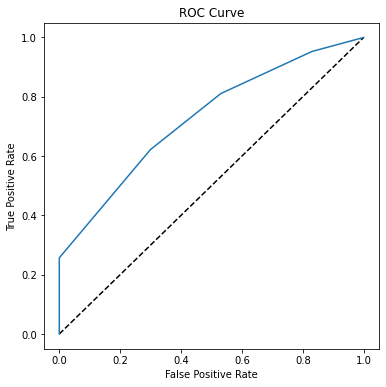

AUC: 0.7270867806582092


In [61]:
# calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_scores[:,1])

# plot ROC curve
fig = plt.figure(figsize=(6, 6))

# Plot the diagonal 50% line
plt.plot([0, 1], [0, 1], 'k--')

# Plot the FPR and TPR achieved by our model
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

# calculate AUC
auc = roc_auc_score(y_test,y_scores[:,1])
print('AUC: ' + str(auc))

### 6. Extreme Gradient Boosting

In [62]:
# Extreme Gradient Boosting
xgbmodel = XGBClassifier(random_state=seed,verbos=0)
xgbmodel.fit(x_train,y_train)
print('xgboost accuracy on trainning:',xgbmodel.score(x_train,y_train))
print('xgboost acurracy on testing:',xgbmodel.score(x_test,y_test))

[11:08:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "verbos" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[11:08:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
xgboost accuracy on trainning: 0.9770603228547153
xgboost acurracy on testing: 0.7627118644067796


In [63]:
#confusion matrix and classification report
y_pred=xgbmodel.predict(x_test)
y_scores=xgbmodel.predict_proba(x_test)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[120  27]
 [ 43 105]]
              precision    recall  f1-score   support

           0       0.74      0.82      0.77       147
           1       0.80      0.71      0.75       148

    accuracy                           0.76       295
   macro avg       0.77      0.76      0.76       295
weighted avg       0.77      0.76      0.76       295



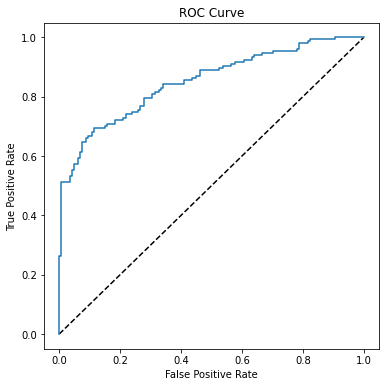

AUC: 0.8509376723662437


In [64]:
# calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_scores[:,1])

# plot ROC curve
fig = plt.figure(figsize=(6, 6))

# Plot the diagonal 50% line
plt.plot([0, 1], [0, 1], 'k--')

# Plot the FPR and TPR achieved by our model
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

# calculate AUC
auc = roc_auc_score(y_test,y_scores[:,1])
print('AUC: ' + str(auc))

## Optimization 

In [65]:
scores=pd.DataFrame()
cv = [(slice(None), slice(None))]

 # Logstic regression
# Model Parameter
params={'C':[1,0.1,0.01,0.001,0.0001],
        'penalty':['l2','l1'],
        'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}

# Train Logstic regression model with Grid Search
model =LogisticRegression(max_iter=10000,random_state=seed)
loggrid=GridSearchCV(model,params ,scoring='accuracy',n_jobs=-1,cv=cv)
loggrid.fit(x_train,y_train)

# Predction
y_pred=loggrid.predict(x_test)
y_scores=loggrid.predict_proba(x_test)

# AUC Score
auc = roc_auc_score(y_test,y_scores[:,1])

# Recall Socre
rec=recall_score(y_test,y_pred)

# Precision Score
prec=precision_score(y_test,y_pred)

# specificity and F1 Score
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
specificity = tn / (tn+fp)
f1=f1_score(y_test,y_pred)

# print score results
print('Logstic regression score in trainning data :',loggrid.score(x_train,y_train))
print('best parameter:',loggrid.best_params_)
print('Logstic regression score in testing :',loggrid.score(x_test,y_test))
scores['Logstic regression']=(loggrid.score(x_train,y_train),loggrid.score(x_test,y_test),auc,rec,prec,specificity,f1)

Logstic regression score in trainning data : 0.7553101104502974
best parameter: {'C': 1, 'penalty': 'l2', 'solver': 'newton-cg'}
Logstic regression score in testing : 0.752542372881356


In [66]:
# KNN
# Model Parameter
params={'n_neighbors':[3,5,9,11,13,15],
        'p':[1,2],
        'weights' : ['uniform','distance'],
        'metric' : ['minkowski','euclidean','manhattan']
}

# train KNN model with Grid Search
model=KNeighborsClassifier()
KNNgrid=GridSearchCV(model,params ,scoring='accuracy',n_jobs=-1,cv=cv)
KNNgrid.fit(x_train,y_train)

# Predction
y_pred=KNNgrid.predict(x_test)
y_scores=KNNgrid.predict_proba(x_test)

# AUC Score
auc = roc_auc_score(y_test,y_scores[:,1])

# Recall Socre
rec=recall_score(y_test,y_pred)

# Precision Score
prec=precision_score(y_test,y_pred)

# specificity and F1 Score
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
specificity = tn / (tn+fp)
f1=f1_score(y_test,y_pred)

# print score results
print('KNN score in trainning data :',KNNgrid.score(x_train,y_train))
print('KNN best parameter:',KNNgrid.best_params_)
print('KNN score in testing :',KNNgrid.score(x_test,y_test))
scores['KNN']=(KNNgrid.score(x_train,y_train),KNNgrid.score(x_test,y_test),auc,rec,prec,specificity,f1)

KNN score in trainning data : 0.989804587935429
KNN best parameter: {'metric': 'minkowski', 'n_neighbors': 3, 'p': 1, 'weights': 'distance'}
KNN score in testing : 0.735593220338983


Decision Tree score in trainning data : 0.8037383177570093
Decision Tree best parameter: {'criterion': 'gini', 'max_depth': 7, 'max_features': 'auto', 'splitter': 'best'}
Decision Tree score in testing : 0.7457627118644068


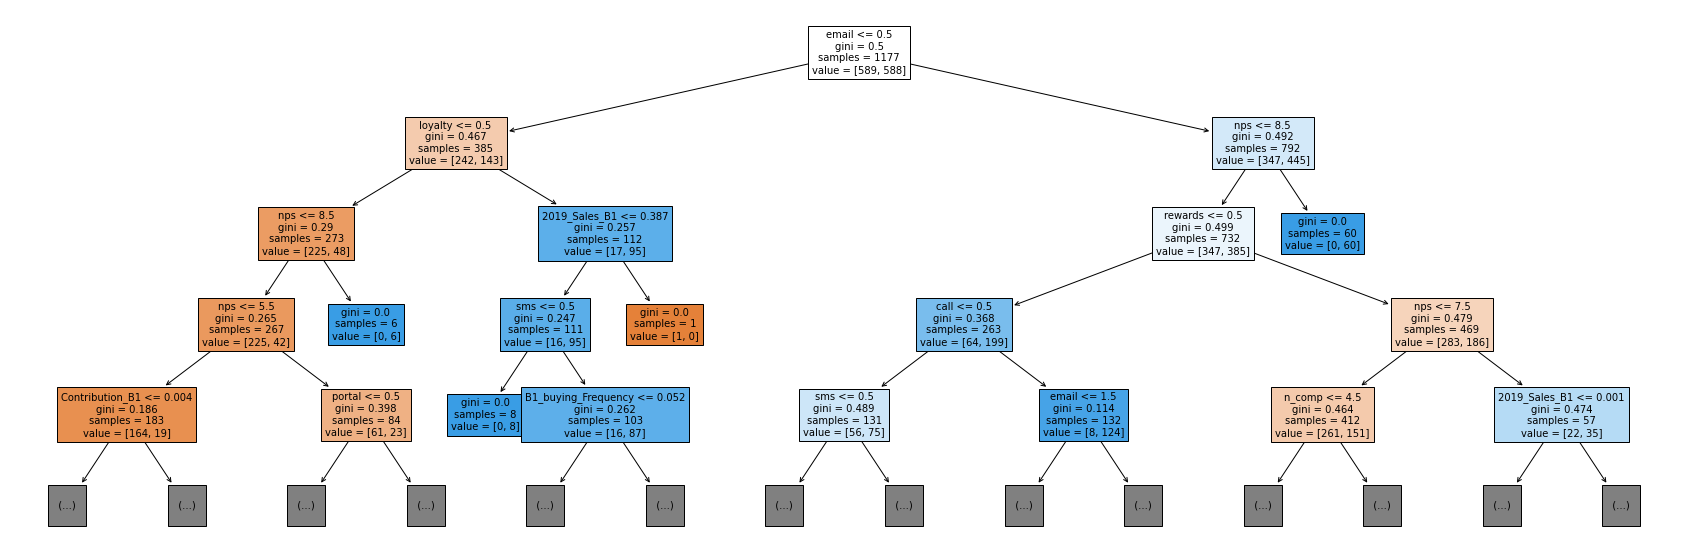

In [67]:
 # Decision Tree
 # Model Parameter
params={'criterion':['entropy','gini'],
        'max_depth':[8,7,6,5,4,3,2,1],
        'max_features':["auto", "sqrt", "log2"],
        'splitter':['random','best']
}

# Train Decision Tree model with Grid Search
model=DecisionTreeClassifier(random_state=seed)
detgrid=GridSearchCV(model,params ,scoring='accuracy',n_jobs=-1,cv=cv)
detgrid.fit(x_train,y_train)

# Predction
y_pred=detgrid.predict(x_test)
y_scores=detgrid.predict_proba(x_test)

# AUC Score
auc = roc_auc_score(y_test,y_scores[:,1])

# Recall Socre
rec=recall_score(y_test,y_pred)

# Precision Score
prec=precision_score(y_test,y_pred)

# specificity and F1 Score
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
specificity = tn / (tn+fp)
f1=f1_score(y_test,y_pred)

# print score results
print('Decision Tree score in trainning data :',detgrid.score(x_train,y_train))
print('Decision Tree best parameter:',detgrid.best_params_)
print('Decision Tree score in testing :',detgrid.score(x_test,y_test))
scores['Decision Tree']=(detgrid.score(x_train,y_train),detgrid.score(x_test,y_test),auc,rec,prec,specificity,f1)

# plot the tree
model=detgrid.best_estimator_.fit(x_train,y_train)
plt.figure(figsize=(30,10))
plot_tree(model,filled=True,feature_names=list(x_train.columns),max_depth=4,fontsize=10)
plt.show()

In [68]:
# Naive Bayes
# Model Parameter
params={'var_smoothing': np.logspace(0,-9, num=100)}

# Train Naive Bayes model with Grid Search
model=GaussianNB()
nbgrid=GridSearchCV(model,params ,scoring='accuracy',n_jobs=-1,cv=cv)
nbgrid.fit(x_train,y_train)

# Predction
y_pred=nbgrid.predict(x_test)
y_scores=nbgrid.predict_proba(x_test)

# AUC Score
auc = roc_auc_score(y_test,y_scores[:,1])

# Recall Socre
rec=recall_score(y_test,y_pred)

# Recall Socre
prec=precision_score(y_test,y_pred)

# specificity and F1 Score
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
specificity = tn / (tn+fp)
f1=f1_score(y_test,y_pred)

# print score results
print('Naive Bayes score in trainning data :',nbgrid.score(x_train,y_train))
print('Naive Bayes best parameter:',nbgrid.best_params_)
print('Naive Bayes score in testing :',nbgrid.score(x_test,y_test))
scores['Naive Bayes']=(nbgrid.score(x_train,y_train),nbgrid.score(x_test,y_test),auc,rec,prec,specificity,f1)

Naive Bayes score in trainning data : 0.6618521665250637
Naive Bayes best parameter: {'var_smoothing': 0.003511191734215131}
Naive Bayes score in testing : 0.6610169491525424


In [69]:
# Random forest
# Model Parameter
params={'n_estimators':[50,70,100],
        'criterion':["gini", "entropy"],
        'max_depth':[7,6,5,4,3,2,1],
        'max_features':["auto", "sqrt", "log2"]
}

# Train Random forest model with Grid Search
model=RandomForestClassifier(random_state=seed)
rfcgrid=GridSearchCV(model,params ,scoring='accuracy',n_jobs=-1,cv=cv)
rfcgrid.fit(x_train,y_train)

# Predction
y_pred=rfcgrid.predict(x_test)
y_scores=rfcgrid.predict_proba(x_test)

# AUC Score
auc = roc_auc_score(y_test,y_scores[:,1])

# Recall Socre
rec=recall_score(y_test,y_pred)

# Precision Score
prec=precision_score(y_test,y_pred)

# specificity and F1 Score
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
specificity = tn / (tn+fp)
f1=f1_score(y_test,y_pred)

# print score results
print('Random forest score in trainning data :',rfcgrid.score(x_train,y_train))
print('Random forest best parameter:',rfcgrid.best_params_)
print('Random forest score in testing :',rfcgrid.score(x_test,y_test))
scores['Random forest']=(rfcgrid.score(x_train,y_train),rfcgrid.score(x_test,y_test),auc,rec,prec,specificity,f1)

Random forest score in trainning data : 0.8394222599830077
Random forest best parameter: {'criterion': 'gini', 'max_depth': 7, 'max_features': 'auto', 'n_estimators': 50}
Random forest score in testing : 0.8033898305084746


In [70]:
# xgboost
# Model Parameter
params={'n_estimators':[50,70,100],
        'max_depth':[6,5,4,3],
        'learning_rate':[0.1,0.01,0.001]}

# Train xgboost model with Grid Search 
model = XGBClassifier(random_state=seed,verbos=0)
xgbgrid=GridSearchCV(model,params ,scoring='accuracy',n_jobs=-1,cv=cv)
xgbgrid.fit(x_train, y_train)

# Predction
y_pred=xgbgrid.predict(x_test)
y_scores=xgbgrid.predict_proba(x_test)

# AUC Score
auc = roc_auc_score(y_test,y_scores[:,1])

# Recall Socre
rec=recall_score(y_test,y_pred)

# Precision Score
prec=precision_score(y_test,y_pred)

# specificity and F1 Score
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
specificity = tn / (tn+fp)
f1=f1_score(y_test,y_pred)

# print score results
print('xgboost score in trainning data :',xgbgrid.score(x_train,y_train))
print('xgboost best parameter:',xgbgrid.best_params_)
print('xgboost score in testing :',xgbgrid.score(x_test,y_test))
scores['xgboost']=(xgbgrid.score(x_train,y_train),xgbgrid.score(x_test,y_test),auc,rec,prec,specificity,f1)

[11:08:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "verbos" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[11:08:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
xgboost score in trainning data : 0.9277824978759558
xgboost best parameter: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 100}
xgboost score in testing : 0.7728813559322034


In [71]:
# score results table
scores.index=['Accuracy in trainning','Accuracy in testing','AUC score','Recall','Precision','Specificity','F1 Score']
scores=scores.T
scores

,Accuracy in trainning,Accuracy in testing,AUC score,Recall,Precision,Specificity,F1 Score
Logstic regression,0.755310,0.752542,0.811454,0.682432,0.795276,0.823129,0.734545
KNN,0.989805,0.735593,0.781279,0.695946,0.757353,0.775510,0.725352
Decision Tree,0.803738,0.745763,0.792862,0.601351,0.847619,0.891156,0.703557
Naive Bayes,0.661852,0.661017,0.744714,0.587838,0.690476,0.734694,0.635036
Random forest,0.839422,0.803390,0.855212,0.702703,0.881356,0.904762,0.781955
xgboost,0.927782,0.772881,0.871162,0.722973,0.804511,0.823129,0.761566


[[133  14]
 [ 44 104]]
              precision    recall  f1-score   support

           0       0.75      0.90      0.82       147
           1       0.88      0.70      0.78       148

    accuracy                           0.80       295
   macro avg       0.82      0.80      0.80       295
weighted avg       0.82      0.80      0.80       295



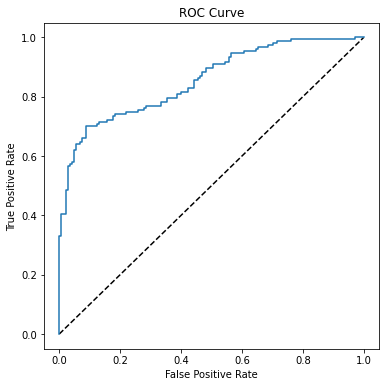

AUC: 0.8552123552123553


In [72]:
# final Model selected
#confusion matrix and classification report
y_pred=rfcgrid.predict(x_test)
y_scores=rfcgrid.predict_proba(x_test)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

# calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_scores[:,1])

# plot ROC curve
fig = plt.figure(figsize=(6, 6))

# Plot the diagonal 50% line
plt.plot([0, 1], [0, 1], 'k--')

# Plot the FPR and TPR achieved by our model
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

# calculate AUC
auc = roc_auc_score(y_test,y_scores[:,1])
print('AUC: ' + str(auc))

In [73]:
# Accuracy on different thresholds
accuracy_ls = []
for thres in thresholds:
    y_pred = np.where(y_scores[:,1]>=thres,1,0)
    accuracy_ls.append(accuracy_score(y_test, y_pred, normalize=True))
thres=pd.DataFrame.from_dict({'thresholds':thresholds,'accuracy':accuracy_ls})
thres.sort_values(by='accuracy',ascending=False).T

,24,28,26,22,18,27,25,20,23,21,16,19,17,30,29,32,34,33,31,12,10,14,13,11,15,36,35,38,37,40,42,39,41,8,9,44,46,43,45,48,54,62,50,60,49,56,52,58,47,64,59,61,55,57,51,6,63,53,70,7,68,66,69,65,67,72,71,73,4,5,74,76,78,75,77,80,82,79,84,81,83,3,2,86,85,88,87,89,1,0
thresholds,0.51164,0.484334,0.48851,0.536553,0.561322,0.485941,0.494426,0.548784,0.526269,0.548369,0.575159,0.550282,0.573209,0.468138,0.468754,0.465000,0.461763,0.464707,0.465949,0.617201,0.623462,0.607871,0.615221,0.618498,0.606567,0.452801,0.454459,0.447071,0.448642,0.442438,0.438539,0.444029,0.439384,0.690848,0.688276,0.429339,0.427026,0.430619,0.427525,0.412558,0.378648,0.347246,0.410555,0.364196,0.411964,0.372765,0.397017,0.365628,0.418507,0.336632,0.365550,0.354099,0.372902,0.367705,0.402891,0.739507,0.337017,0.391939,0.321926,0.732306,0.324418,0.327068,0.323655,0.327602,0.325745,0.305799,0.306642,0.301739,0.783535,0.778938,0.295846,0.287139,0.284190,0.288210,0.285843,0.267807,0.260317,0.269050,0.251098,0.260594,0.260006,0.833266,0.835098,0.244079,0.245122,0.149082,0.155356,0.097044,0.990526,1.990526
accuracy,0.80678,0.793220,0.79322,0.793220,0.793220,0.789831,0.789831,0.789831,0.786441,0.786441,0.786441,0.786441,0.783051,0.783051,0.779661,0.779661,0.779661,0.776271,0.772881,0.769492,0.769492,0.769492,0.766102,0.766102,0.766102,0.766102,0.762712,0.749153,0.745763,0.742373,0.742373,0.738983,0.738983,0.732203,0.728814,0.725424,0.722034,0.718644,0.715254,0.711864,0.708475,0.708475,0.708475,0.708475,0.705085,0.705085,0.705085,0.705085,0.705085,0.705085,0.701695,0.701695,0.701695,0.701695,0.698305,0.698305,0.698305,0.694915,0.691525,0.691525,0.688136,0.688136,0.684746,0.684746,0.681356,0.674576,0.671186,0.667797,0.664407,0.661017,0.661017,0.657627,0.657627,0.654237,0.654237,0.644068,0.640678,0.640678,0.637288,0.637288,0.633898,0.623729,0.616949,0.616949,0.613559,0.515254,0.511864,0.501695,0.501695,0.498305


<AxesSubplot:title={'center':'Lift Curve'}, xlabel='Percentage of sample', ylabel='Lift'>

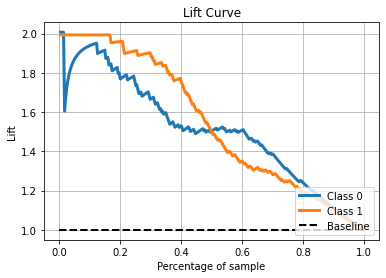

In [74]:
# Lift Curve
plot_lift_curve(y_test,y_scores)

In [76]:
# KS statistic test
pred=pd.DataFrame(y_scores[:,1], columns=['pred'])
res0=pred.loc[y_test.reset_index(drop=True).response==0,'pred']
res1=pred.loc[y_test.reset_index(drop=True).response==1,'pred']
max_diff,p_value=ks_2samp(res0,res1)
print('maxiumum difference:',max_diff)
print('p-value:',p_value)

maxiumum difference: 0.6142673285530429
p-value: 2.1995779767573124e-27


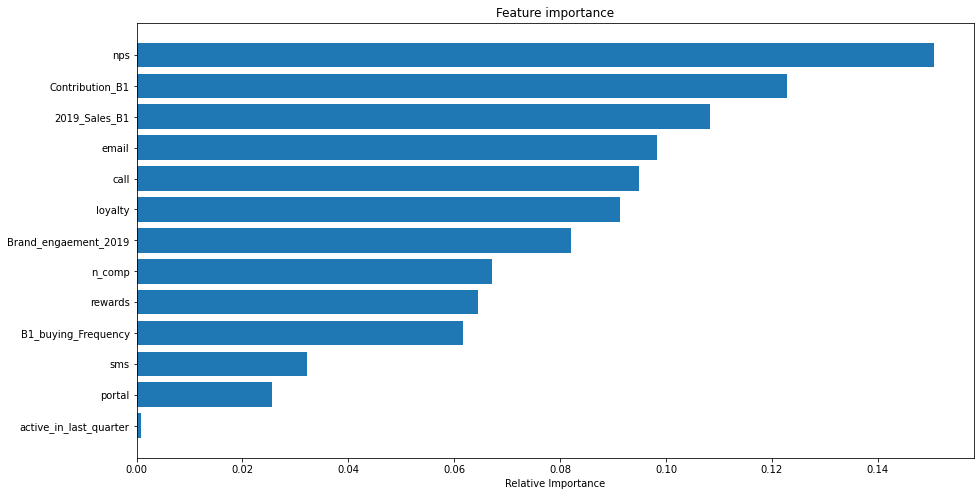

In [82]:
# summarize feature importance
model=rfcgrid.best_estimator_.fit(x_test,y_test)
features=list(x_train.columns)
importance=model.feature_importances_
indeces=np.argsort(importance)
fig=plt.figure(figsize=(15,8))
plt.title('Feature importance')
plt.barh(range(len(indeces)),importance[indeces],align='center')
plt.xlabel('Relative Importance')
plt.yticks(range(len(indeces)),[features[i]for i in indeces])
plt.show()

## Insights and actions to take
### 1. Use email and call respectively in future campaign where they have great influence in customer responsiveness to campaign and avoid using SMS.
### 2. avoid  email or call the channel partner more than 2 times which will not have impact in customers responses.
### 3. Regions have consistency performance.
### 4. Work with Channel partner with less Net Promote scorer to increase it. 
